In [3]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

RAW_DATA_DIR = "DataSet/signatures"          # your dataset
PROCESSED_DIR = "DataSet/processed_data"     # auto-generated


In [31]:
def prepare_dataset(raw_dir, out_dir):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)

    for split in ["train", "val", "test"]:
        for cls in ["genuine", "forged"]:
            os.makedirs(os.path.join(out_dir, split, cls), exist_ok=True)

    writers = sorted([
        d for d in os.listdir(raw_dir)
        if os.path.isdir(os.path.join(raw_dir, d)) and not d.endswith("_forg")
    ])

    for writer in writers:
        genuine_dir = os.path.join(raw_dir, writer)
        forged_dir  = os.path.join(raw_dir, writer + "_forg")

        genuine_imgs = os.listdir(genuine_dir)
        forged_imgs  = os.listdir(forged_dir)

        random.shuffle(genuine_imgs)
        random.shuffle(forged_imgs)

        # -------- FIXED SPLIT --------
        def split(files):
            if len(files) < 3:
                return files, [], []

            train = files[:-2]
            val   = [files[-2]]
            test  = [files[-1]]
            return train, val, test

        g_train, g_val, g_test = split(genuine_imgs)
        f_train, f_val, f_test = split(forged_imgs)

        for f in g_train:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "train", "genuine", f"{writer}_{f}"))
        for f in g_val:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "val", "genuine", f"{writer}_{f}"))
        for f in g_test:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "test", "genuine", f"{writer}_{f}"))

        for f in f_train:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "train", "forged", f"{writer}_{f}"))
        for f in f_val:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "val", "forged", f"{writer}_{f}"))
        for f in f_test:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "test", "forged", f"{writer}_{f}"))

    print("✅ Dataset prepared correctly (train/val/test all non-empty)")


In [32]:
prepare_dataset(RAW_DATA_DIR, PROCESSED_DIR)


✅ Dataset prepared correctly (train/val/test all non-empty)


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names


Found 288 files belonging to 2 classes.
Found 96 files belonging to 2 classes.
Found 96 files belonging to 2 classes.


In [6]:
data_aug = tf.keras.Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")


In [35]:
def build_improved_cnn():
    model = models.Sequential([
        layers.Input((*IMG_SIZE, 3)),
        data_aug,

        # Block 1
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [36]:
cnn_model = build_improved_cnn()

cnn_hist = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.4688 - auc: 0.4859 - loss: 0.9967 - precision: 0.4717 - recall: 0.5208 - val_accuracy: 0.5000 - val_auc: 0.5267 - val_loss: 0.6978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5104 - auc: 0.5014 - loss: 0.8795 - precision: 0.5103 - recall: 0.5139 - val_accuracy: 0.5000 - val_auc: 0.5527 - val_loss: 0.7163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4618 - auc: 0.4607 - loss: 0.9818 - precision: 0.4645 - recall: 0.5000 - val_accuracy: 0.5000 - val_auc: 0.6109 - val_loss: 0.7080 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4688 - auc: 0.4605 - loss: 0.9013 - precision: 0.4698 - recall: 0.4861 - val_accuracy: 0.5000 - val_auc: 0.5638 - val_loss: 0.74

In [7]:
def build_mobilenet():
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    inputs = layers.Input((*IMG_SIZE, 3))
    x = data_aug(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [8]:
mb_model = build_mobilenet()

mb_hist = mb_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 847ms/step - accuracy: 0.4931 - auc: 0.4923 - loss: 1.0311 - precision: 0.4936 - recall: 0.5347 - val_accuracy: 0.4583 - val_auc: 0.5265 - val_loss: 0.7217 - val_precision: 0.4722 - val_recall: 0.7083
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 655ms/step - accuracy: 0.5590 - auc: 0.5985 - loss: 0.8448 - precision: 0.5620 - recall: 0.5347 - val_accuracy: 0.4896 - val_auc: 0.5677 - val_loss: 0.7094 - val_precision: 0.4930 - val_recall: 0.7292
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 647ms/step - accuracy: 0.5521 - auc: 0.5740 - loss: 0.8924 - precision: 0.5510 - recall: 0.5625 - val_accuracy: 0.5312 - val_auc: 0.5987 - val_loss: 0.7126 - val_precision: 0.5211 - val_recall: 0.7708
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 718ms/step - accuracy: 0.4861 - auc: 0.5334 - loss: 0.9807 - precision: 0.4861 - recall: 0.4861 - val_accuracy: 0.6354 - val_auc: 0.6319 - val_loss: 0.6764 - val_precision: 0.6383 - val_recall: 0.6250
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 

In [9]:
mb_model.layers[2].trainable = True   # unfreeze MobileNet backbone

mb_model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.AUC()]
)

mb_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5312 - auc: 0.5664 - loss: 0.8941 - precision: 0.5290 - recall: 0.5694 - val_accuracy: 0.5938 - val_auc: 0.6691 - val_loss: 0.6536 - val_precision: 0.5849 - val_recall: 0.6458
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4965 - auc: 0.4948 - loss: 1.0232 - precision: 0.4964 - recall: 0.4792 - val_accuracy: 0.6042 - val_auc: 0.6753 - val_loss: 0.6532 - val_precision: 0.6000 - val_recall: 0.6250
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4861 - auc: 0.5051 - loss: 0.9821 - precision: 0.4868 - recall: 0.5139 - val_accuracy: 0.6250 - val_auc: 0.6825 - val_loss: 0.6529 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5069 - auc: 0.5082 - loss: 0.9751 - precision: 0.5072 - recall: 0.4861 - val_accuracy: 0.6354 - val_auc: 0.6819 - val_loss: 0.6551 - val_precision: 0.6444 - val_recall: 0.6042
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step 

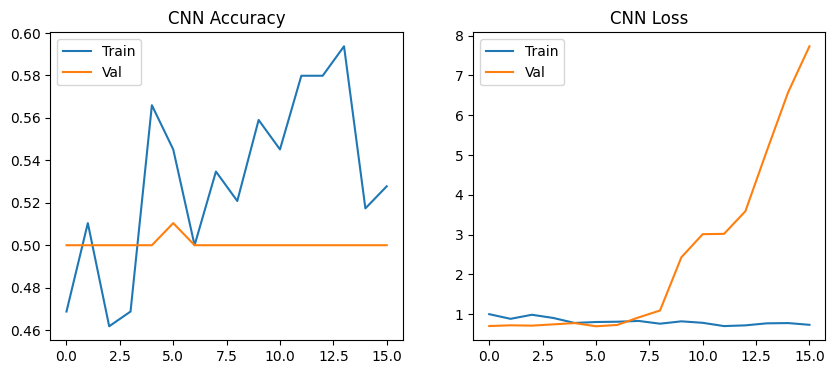

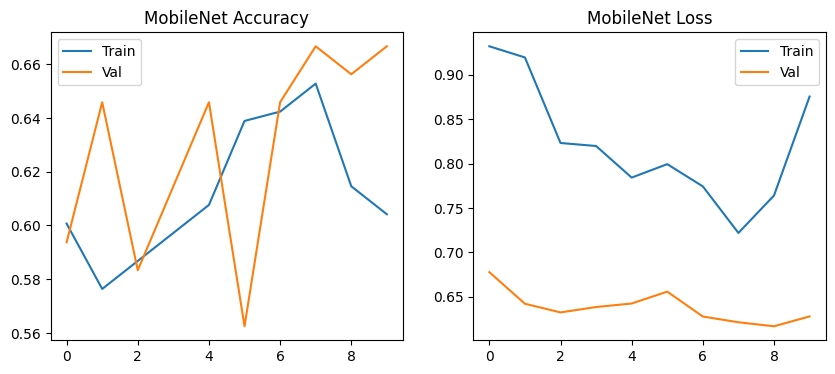

In [40]:
def plot_history(hist, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title + " Accuracy")
    plt.legend(["Train","Val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title + " Loss")
    plt.legend(["Train","Val"])
    plt.show()

plot_history(cnn_hist, "CNN")
plot_history(mb_hist, "MobileNet")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 364ms/step
              precision    recall  f1-score   support

      forged       0.59      0.75      0.66        48
     genuine       0.66      0.48      0.55        48

    accuracy                           0.61        96
   macro avg       0.62      0.61      0.61        96
weighted avg       0.62      0.61      0.61        96



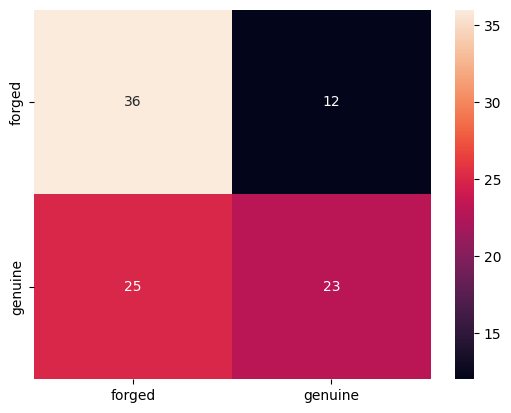

In [41]:
def evaluate(model):
    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = (model.predict(test_ds) > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.show()

evaluate(mb_model)


In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def verify_signature_with_display(genuine_img, test_img, model, threshold=0.15):
    def _load_and_predict(img_path):
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        arr = tf.keras.utils.img_to_array(img)
        arr = np.expand_dims(arr, 0)  # no manual normalization
        score = float(model.predict(arr, verbose=0)[0][0])
        return img, score

    g_img, g_score = _load_and_predict(genuine_img)
    t_img, t_score = _load_and_predict(test_img)

    diff = abs(g_score - t_score)
    is_match = diff < threshold

    result_text = "MATCH (Likely Genuine)" if is_match else "NOT MATCH (Likely Forged)"

    # ---- DISPLAY ----
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(g_img)
    plt.axis("off")
    plt.title(f"Genuine\nScore: {g_score:.4f}")

    plt.subplot(1, 2, 2)
    plt.imshow(t_img)
    plt.axis("off")
    plt.title(f"Test\nScore: {t_score:.4f}")

    plt.suptitle(
        f"{result_text}\nDifference: {diff:.4f} | Threshold: {threshold}",
        fontsize=12,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    return {
        "genuine_score": g_score,
        "test_score": t_score,
        "difference": diff,
        "threshold": threshold,
        "result": result_text
    }


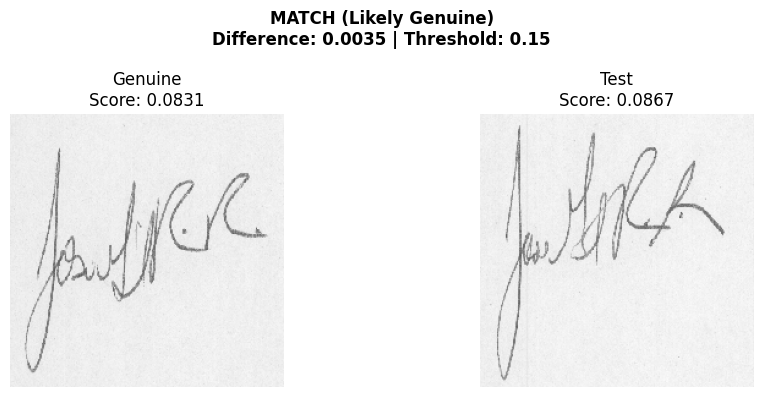

{'genuine_score': 0.083144411444664,
 'test_score': 0.08667756617069244,
 'difference': 0.0035331547260284424,
 'threshold': 0.15,
 'result': 'MATCH (Likely Genuine)'}

In [11]:
verify_signature_with_display(
    r"C:\Users\hp\Downloads\sign_detc_verf-main\sign_detc_verf-main\DataSet\full_org\original_3_16.png",
    r"C:\Users\hp\Downloads\sign_detc_verf-main\sign_detc_verf-main\DataSet\full_org\original_3_17.png",
    mb_model,
    threshold=0.15
)



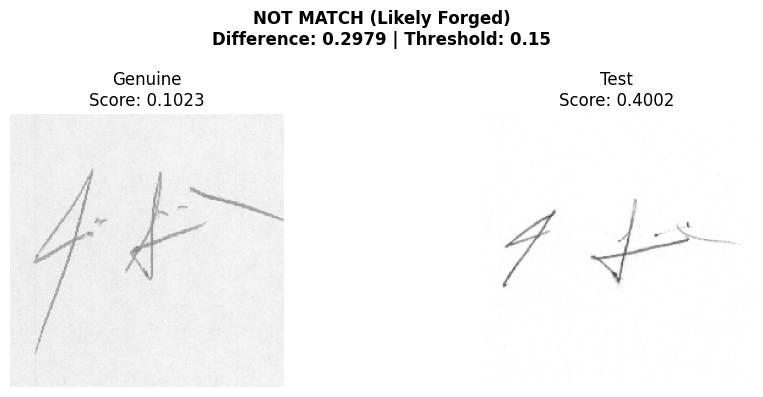

{'genuine_score': 0.1022908166050911,
 'test_score': 0.40015745162963867,
 'difference': 0.2978666350245476,
 'threshold': 0.15,
 'result': 'NOT MATCH (Likely Forged)'}

In [21]:
verify_signature_with_display(
    r"C:\Users\hp\Downloads\sign_detc_verf-main\sign_detc_verf-main\DataSet\full_org\original_1_1.png",
    r"C:\Users\hp\Downloads\sign_detc_verf-main\sign_detc_verf-main\DataSet\full_forg\forgeries_1_1.png",
    mb_model,
    threshold=0.15
)